In [1]:
U_new_total = []
utm_loc_new_total = []

U_total = []
utm_loc_total = []

in linux
>>>>num_objects: 5
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (27, 3)
x,y,r:  97 137 4
# of points:  (16, 3)
x,y,r:  124 71 3
>>>> start to ICP >>>>
dist:  [[ 1.89657663  5.70400163 19.57194561 24.77433518]
 [ 1.91613932  2.2950712  16.01420061 21.31415979]]
match point:  [(0, 0), (1, 0)]
matched same ref landmarks!
changed point:  [(0, 0), (1, 1)]
det(vh@u.T):  0.9999999999999999
R:  [[ 0.9952806  -0.09703883]
 [ 0.09703883  0.9952806 ]]
theta (deg):  -5.568678191606996
translation:  [[1.70308353]
 [1.21600124]]
residual =  0.3577433817554265
iteration time:  1


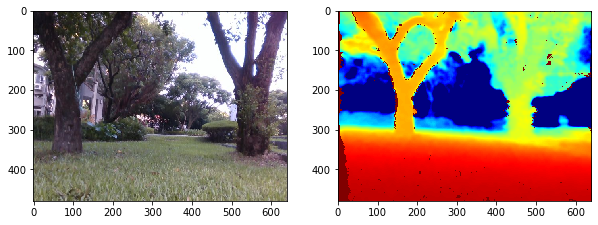

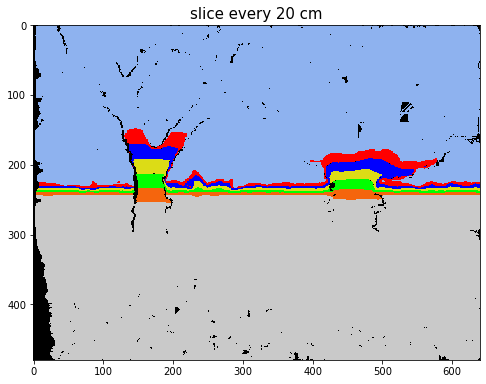

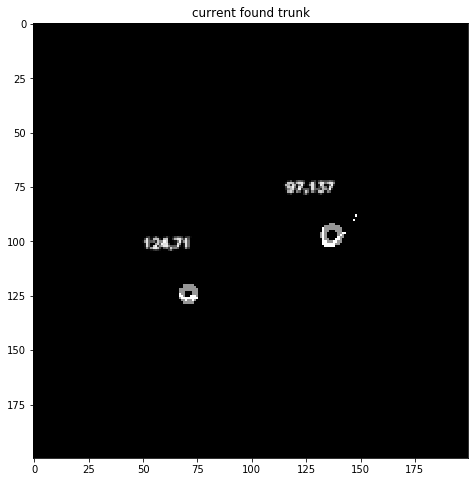

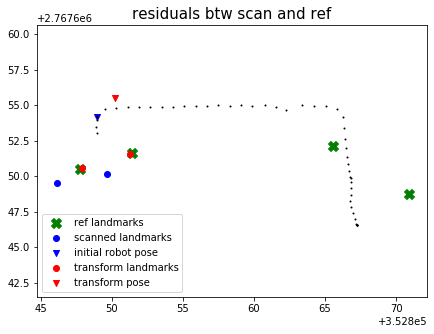

In [2]:
'''math tool'''
import csv
import numpy as np
from scipy.spatial import distance as dist

'''plot tool'''
import matplotlib.pyplot as plt
import matplotlib.cm as cm

'''image tool'''
import cv2
import statistics as sta

import utm
from pyproj import Proj
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/5/"

''' show raw data '''
npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")
npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

''' to world coordinate '''
cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

''' depth segmentation: show layers '''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
npHeight_seg = npHeight_seg.astype('uint8')
fig2,ax = plt.subplots(figsize=(8,8))
plt.title('slice every 20 cm', fontsize=15)
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

''' top-down view grid '''
def depth_Z(u,v):
    return npDepth[v][u]
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100] += 1
                    
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[plane_l1>8]=255
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)
# fig, ax = plt.subplots(figsize=(8,8))
# plt.title('filter grid > 4', fontsize=15)
# plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

''' find connected component and push into point array A '''
num_objects, labels = cv2.connectedComponents(hieght_or)
centre_x_list = []
centre_y_list = []
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)
for i in range(num_objects-1):
    A = []
    for x in range(200):
        for y in range(200):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    cv2.circle(circle_bd,(int(centre_y+0.5), int(centre_x+0.5)), int(radius_r+0.5), 150, 2)
    
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))

    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x+0.5))+','+str(int(centre_y+0.5)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke
circle_bd[hieght_or==255]=255
centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)

fig3 = plt.figure(figsize=(8,8))
plt.title('current found trunk')
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

''' load robot current pose '''
with open(file_path+'cb_pose.csv', 'r') as csvfile:
    imu_yaw, lat, lng = csv.reader(csvfile, delimiter=',')
imu_yaw = float(imu_yaw[0])
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lng, lat)

cX_m_loc = (centre_y_list-100)*0.05
cY_m_loc = (200-centre_x_list)*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw) + utm_y_loc
center_utm_loc = np.vstack((cX_utm_loc,cY_utm_loc))
np.save(file_path+'center_utm_loc', center_utm_loc) #############3

''' load landmark map '''
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path_map = directory+bag_name
center_utm_ref = np.load(file_path_map+'center_utm_ref.npy')

cX_utm_ref = center_utm_ref[0,:]
cY_utm_ref = center_utm_ref[1,:]
# fig4 = plt.figure(figsize=(8,8))
# plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='reference landmarks', marker='X',s=100)
# # plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
# plt.axis('equal')
# plt.title('global map in UTM', fontsize=15)
# plt.legend()
# plt.draw()

''' find rigid transformation '''
P = center_utm_ref
U = center_utm_loc
resid_scalar = 50

def find_second(row_index, first_min):
    second_min = 100
    sm_index = 0
    row_list = D[row_index,:]
    for i in range(len(row_list)):
        if row_list[i] != first_min:
            if row_list[i] < second_min:
                second_min = row_list[i]
                sm_index = i
    
    return second_min, sm_index
count = 0
while resid_scalar > 1:
    count += 1
    D = dist.cdist(U.T, P.T)
    print('>>>> start to ICP >>>>')
    print('dist: ', D)
    # rows = D.min(axis=1)
    cols = D.argmin(axis=1)
    print('match point: ', list(enumerate(cols)))

    for a in range(len(cols)):
        b=1
        while a+b < len(cols):
            if cols[a] == cols[a+b]:
                print("matched same ref landmarks!")
                second_min_A,A = find_second(a,D[a,cols[a]])
                second_min_B,B = find_second(a+b,D[a+b,cols[a+b]])
                if second_min_A>second_min_B:
                    cols[a+b]=B
                elif second_min_A<second_min_B:
                    cols[a]=A
                print('changed point: ', list(enumerate(cols)))
            b+=1
        
    Q = np.zeros(U.shape)
    for (row, col) in enumerate(cols):
        Q[:,row] = P[:,col]

    U_bar = np.array([np.average(U, axis=1)])
    U_bar = U_bar.T
    Q_bar = np.array([np.average(Q, axis=1)])
    Q_bar = Q_bar.T

    X = U-U_bar
    Y = Q-Q_bar
    S = X @ Y.T
    u, s, vh = np.linalg.svd(S)
    # check u, vh det
    print('det(vh@u.T): ',np.linalg.det(vh@u.T))
    det = np.linalg.det(vh@u.T)
    if det>0:
        tmp = np.array([[1,0],[0,1]])
    else: 
        tmp = np.array([[1,0],[0,-1]])
    R = vh @ tmp @ u.T
    t = Q_bar-U_bar

    print('R: ',R)
    print('theta (deg): ',(np.arctan2(-R[1,0], R[0,0]))/np.pi*180)
    print('translation: ',t)
    U_new = R@X+U_bar+t
    utm_loc = np.array([[utm_x_loc],[utm_y_loc]])
    utm_loc_decentral = utm_loc-U_bar
    utm_loc_new = R@utm_loc_decentral+U_bar+t

    # calculate residuals
    residuals = Q-U_new
    residuals = np.absolute(residuals)
    resid_scalar = residuals.sum()
    print("residual = ",resid_scalar)
    U = U_new
    print("iteration time: ", count)
    if count>4:
        print("iterate over 5 times!!")
        break

''' plot result '''
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
fig5 = plt.figure(figsize=(7,5))
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='initial robot pose',c='b', marker="v")
plt.scatter(traj_x[0:len(traj_x)-300:100], traj_y[0:len(traj_y)-300:100],c='black',s=1)

plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

In [17]:
U_new_total.append(U_new)
utm_loc_new_total.append(utm_loc_new)

U_total.append(np.array([cX_utm_loc,cY_utm_loc]))
utm_loc_total.append(np.array([[utm_x_loc],[utm_y_loc]]))

In [18]:
U_new_total = np.asarray(U_new_total)
utm_loc_new_total = np.asarray(utm_loc_new_total)
U_total = np.asarray(U_total)
utm_loc_total = np.asarray(utm_loc_total)

In [15]:
# U_new_total=U_new_total.tolist()
utm_loc_new_total = utm_loc_new_total.tolist()
U_total = U_total.tolist()
utm_loc_total = utm_loc_total.tolist()

>>>>num_objects: 7
# of points:  (6, 3)
# of points:  (1, 3)
# of points:  (38, 3)
x,y,r:  104 139 4
# of points:  (1, 3)
# of points:  (1, 3)
# of points:  (24, 3)
x,y,r:  130 72 4
>>>> start to ICP >>>>
dist:  [[ 1.90899453  5.72127702 19.59510725 24.80075687]
 [ 1.93358903  2.30571909 16.00612401 21.29991672]]
match point:  [(0, 0), (1, 0)]
matched same ref landmarks!
changed point:  [(0, 0), (1, 1)]
det(vh@u.T):  0.9999999999999999
R:  [[ 0.99362138 -0.11276773]
 [ 0.11276773  0.99362138]]
theta (deg):  -6.474888052346497
translation:  [[1.70995732]
 [1.22286473]]
residual =  0.32293574564391747
iteration time:  1


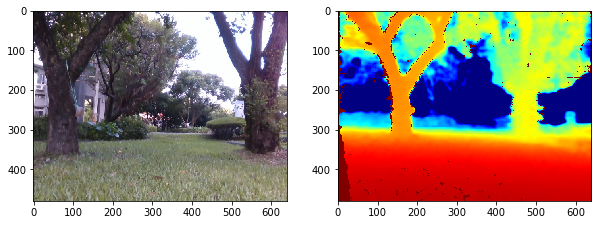

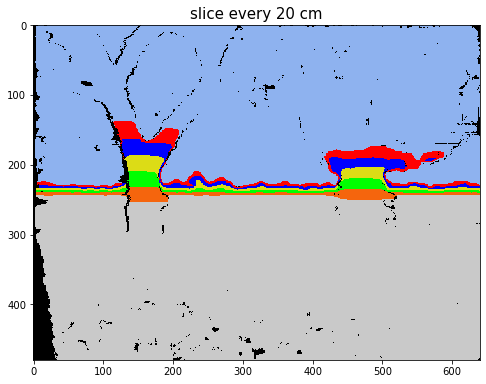

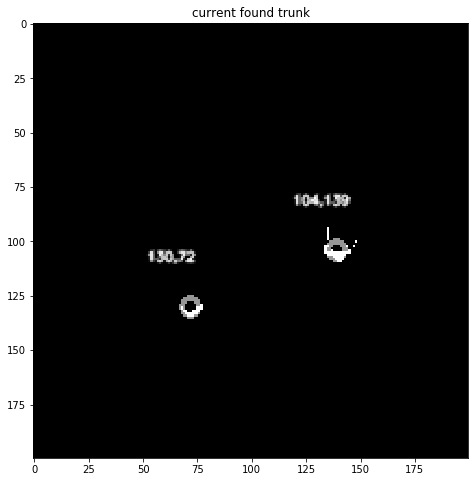

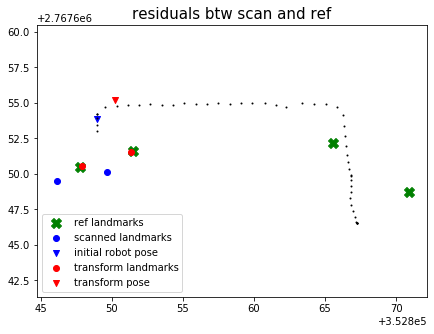

In [4]:
file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/10/"

''' show raw data '''
npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")
npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

''' to world coordinate '''
cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

''' depth segmentation: show layers '''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
npHeight_seg = npHeight_seg.astype('uint8')
fig2,ax = plt.subplots(figsize=(8,8))
plt.title('slice every 20 cm', fontsize=15)
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

''' top-down view grid '''
def depth_Z(u,v):
    return npDepth[v][u]
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100] += 1
                    
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[plane_l1>8]=255
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)
# fig, ax = plt.subplots(figsize=(8,8))
# plt.title('filter grid > 4', fontsize=15)
# plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

''' find connected component and push into point array A '''
num_objects, labels = cv2.connectedComponents(hieght_or)
centre_x_list = []
centre_y_list = []
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)
for i in range(num_objects-1):
    A = []
    for x in range(200):
        for y in range(200):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    cv2.circle(circle_bd,(int(centre_y+0.5), int(centre_x+0.5)), int(radius_r+0.5), 150, 2)
    
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))

    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x+0.5))+','+str(int(centre_y+0.5)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke
circle_bd[hieght_or==255]=255
centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)

fig3 = plt.figure(figsize=(8,8))
plt.title('current found trunk')
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

''' load robot current pose '''
with open(file_path+'cb_pose.csv', 'r') as csvfile:
    imu_yaw, lat, lng = csv.reader(csvfile, delimiter=',')
imu_yaw = float(imu_yaw[0])
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lng, lat)

cX_m_loc = (centre_y_list-100)*0.05
cY_m_loc = (200-centre_x_list)*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw) + utm_y_loc
center_utm_loc = np.vstack((cX_utm_loc,cY_utm_loc))
np.save(file_path+'center_utm_loc', center_utm_loc) #############3

''' load landmark map '''
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path_map = directory+bag_name
center_utm_ref = np.load(file_path_map+'center_utm_ref.npy')

cX_utm_ref = center_utm_ref[0,:]
cY_utm_ref = center_utm_ref[1,:]
# fig4 = plt.figure(figsize=(8,8))
# plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='reference landmarks', marker='X',s=100)
# # plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
# plt.axis('equal')
# plt.title('global map in UTM', fontsize=15)
# plt.legend()
# plt.draw()

''' find rigid transformation '''
P = center_utm_ref
U = center_utm_loc
resid_scalar = 50

def find_second(row_index, first_min):
    second_min = 100
    sm_index = 0
    row_list = D[row_index,:]
    for i in range(len(row_list)):
        if row_list[i] != first_min:
            if row_list[i] < second_min:
                second_min = row_list[i]
                sm_index = i
    
    return second_min, sm_index
count = 0
while resid_scalar > 1:
    count += 1
    D = dist.cdist(U.T, P.T)
    print('>>>> start to ICP >>>>')
    print('dist: ', D)
    # rows = D.min(axis=1)
    cols = D.argmin(axis=1)
    print('match point: ', list(enumerate(cols)))

    for a in range(len(cols)):
        b=1
        while a+b < len(cols):
            if cols[a] == cols[a+b]:
                print("matched same ref landmarks!")
                second_min_A,A = find_second(a,D[a,cols[a]])
                second_min_B,B = find_second(a+b,D[a+b,cols[a+b]])
                if second_min_A>second_min_B:
                    cols[a+b]=B
                elif second_min_A<second_min_B:
                    cols[a]=A
                print('changed point: ', list(enumerate(cols)))
            b+=1
        
    Q = np.zeros(U.shape)
    for (row, col) in enumerate(cols):
        Q[:,row] = P[:,col]

    U_bar = np.array([np.average(U, axis=1)])
    U_bar = U_bar.T
    Q_bar = np.array([np.average(Q, axis=1)])
    Q_bar = Q_bar.T

    X = U-U_bar
    Y = Q-Q_bar
    S = X @ Y.T
    u, s, vh = np.linalg.svd(S)
    # check u, vh det
    print('det(vh@u.T): ',np.linalg.det(vh@u.T))
    det = np.linalg.det(vh@u.T)
    if det>0:
        tmp = np.array([[1,0],[0,1]])
    else: 
        tmp = np.array([[1,0],[0,-1]])
    R = vh @ tmp @ u.T
    t = Q_bar-U_bar

    print('R: ',R)
    print('theta (deg): ',(np.arctan2(-R[1,0], R[0,0]))/np.pi*180)
    print('translation: ',t)
    U_new = R@X+U_bar+t
    utm_loc = np.array([[utm_x_loc],[utm_y_loc]])
    utm_loc_decentral = utm_loc-U_bar
    utm_loc_new = R@utm_loc_decentral+U_bar+t

    # calculate residuals
    residuals = Q-U_new
    residuals = np.absolute(residuals)
    resid_scalar = residuals.sum()
    print("residual = ",resid_scalar)
    U = U_new
    print("iteration time: ", count)
    if count>4:
        print("iterate over 5 times!!")
        break

''' plot result '''
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
fig5 = plt.figure(figsize=(7,5))
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='initial robot pose',c='b', marker="v")
plt.scatter(traj_x[0:len(traj_x)-300:100], traj_y[0:len(traj_y)-300:100],c='black',s=1)

plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

In [5]:
utm_loc_new

array([[ 352850.20765222],
       [2767655.16953268]])

In [6]:
utm_x_loc

352848.9580668035

In [9]:
colors = cm.rainbow(np.linspace(1, 0, 4))

In [32]:
utm_loc_total[1,0,:]

array([352850.20518533])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

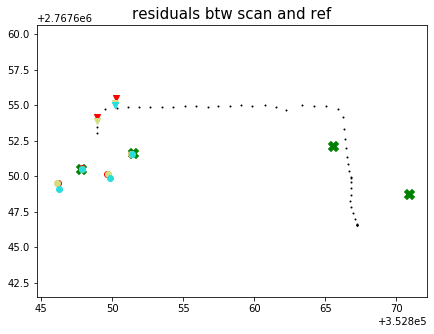

In [19]:
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
fig5 = plt.figure(figsize=(7,5))
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
plt.scatter(traj_x[0:len(traj_x)-300:100], traj_y[0:len(traj_y)-300:100],c='black',s=1)

plt.scatter(U_total[0,0,:], U_total[0,1,:], label='scanned landmarks',c=colors[0])
plt.scatter(utm_loc_total[0,0,:], utm_loc_total[0,1,:], label='initial robot pose',c=colors[0], marker="v")
plt.scatter(U_new_total[0,0,:], U_new_total[0,1,:], label='transform landmarks',c=colors[0])
plt.scatter(utm_loc_new_total[0,0,:], utm_loc_new_total[0,1,:], label='transform pose',c=colors[0], marker="v")

plt.scatter(U_total[1,0,:], U_total[1,1,:], label='scanned landmarks',c=colors[1])
plt.scatter(utm_loc_total[1,0,:], utm_loc_total[1,1,:], label='initial robot pose',c=colors[1], marker="v")
plt.scatter(U_new_total[1,0,:], U_new_total[1,1,:], label='transform landmarks',c=colors[1])
plt.scatter(utm_loc_new_total[1,0,:], utm_loc_new_total[1,1,:], label='transform pose',c=colors[1], marker="v")

plt.scatter(U_total[2,0,:], U_total[2,1,:], label='scanned landmarks',c=colors[2])
plt.scatter(utm_loc_total[2,0,:], utm_loc_total[2,1,:], label='initial robot pose',c=colors[2], marker="v")
plt.scatter(U_new_total[2,0,:], U_new_total[2,1,:], label='transform landmarks',c=colors[2])
plt.scatter(utm_loc_new_total[2,0,:], utm_loc_new_total[2,1,:], label='transform pose',c=colors[2], marker="v")

# plt.scatter(U_total[3,0,:], U_total[3,1,:], label='scanned landmarks',c=colors[3])
# plt.scatter(utm_loc_total[3,0,:], utm_loc_total[3,1,:], label='initial robot pose',c=colors[3], marker="v")
# plt.scatter(U_new_total[3,0,:], U_new_total[3,1,:], label='transform landmarks',c=colors[3])
# plt.scatter(utm_loc_new_total[3,0,:], utm_loc_new_total[3,1,:], label='transform pose',c=colors[3], marker="v")


plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
# plt.legend()
plt.show()

In [18]:
U_total

array([[[ 352846.13395454,  352849.66958204],
        [2767649.5096077 , 2767650.15135393]],

       [[ 352846.24752533,  352849.86472923],
        [2767649.09268965, 2767649.89321195]],

       [[ 352846.31057329,  352849.9848004 ],
        [2767649.02233138, 2767649.94567053]]])

>>>>num_objects: 5
# of points:  (4, 3)
# of points:  (2, 3)
# of points:  (48, 3)
x,y,r:  107 140 5
# of points:  (24, 3)
x,y,r:  134 71 6
>>>> start to ICP >>>>
dist:  [[ 2.06977409  5.78457431 19.54327545 24.67779996]
 [ 2.18284287  2.34014383 15.84708167 21.08953864]]
match point:  [(0, 0), (1, 0)]
matched same ref landmarks!
changed point:  [(0, 0), (1, 1)]
det(vh@u.T):  0.9999999999999999
R:  [[ 0.99720658 -0.07469294]
 [ 0.07469294  0.99720658]]
theta (deg):  -4.283579779125548
translation:  [[1.55559833]
 [1.56039475]]
residual =  0.18422812392236665
iteration time:  1
>>>> start to ICP >>>>
dist:  [[ 0.07393291  3.77865962 17.78754573 23.15304805]
 [ 3.77865962  0.07393291 14.17688379 19.7435622 ]]
match point:  [(0, 0), (1, 1)]
det(vh@u.T):  1.0
R:  [[ 1.0000000e+00  2.4872937e-11]
 [-2.4872937e-11  1.0000000e+00]]
theta (deg):  1.4251143166780396e-09
translation:  [[0.]
 [0.]]
residual =  0.18422812392236665
iteration time:  2
>>>> start to ICP >>>>
dist:  [[ 0.07393291  3.7

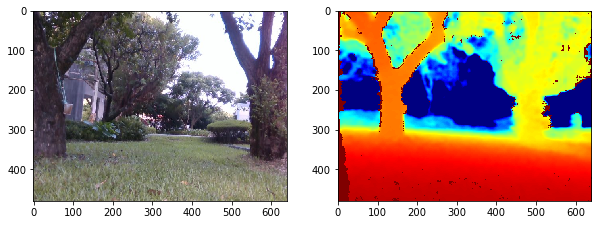

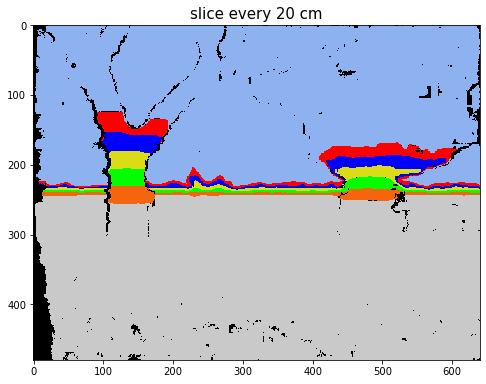

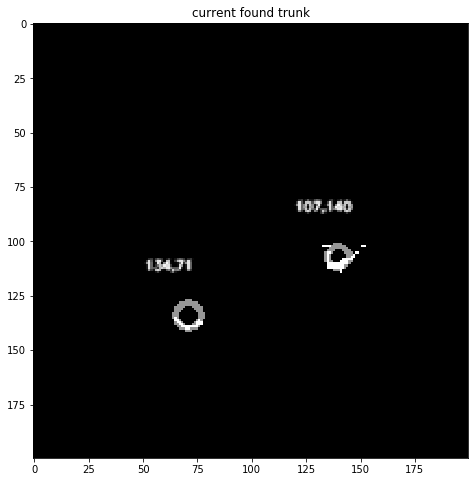

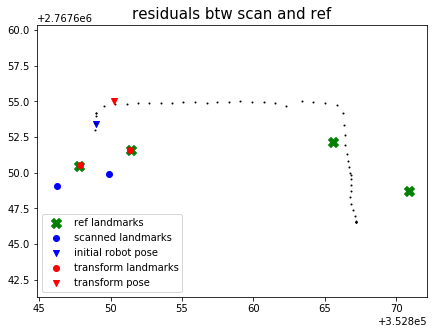

In [16]:
file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/15/"

''' show raw data '''
npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")
npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

''' to world coordinate '''
cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

''' depth segmentation: show layers '''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
npHeight_seg = npHeight_seg.astype('uint8')
fig2,ax = plt.subplots(figsize=(8,8))
plt.title('slice every 20 cm', fontsize=15)
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

''' top-down view grid '''
def depth_Z(u,v):
    return npDepth[v][u]
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100] += 1
                    
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[plane_l1>8]=255
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)
# fig, ax = plt.subplots(figsize=(8,8))
# plt.title('filter grid > 4', fontsize=15)
# plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

''' find connected component and push into point array A '''
num_objects, labels = cv2.connectedComponents(hieght_or)
centre_x_list = []
centre_y_list = []
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)
for i in range(num_objects-1):
    A = []
    for x in range(200):
        for y in range(200):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    cv2.circle(circle_bd,(int(centre_y+0.5), int(centre_x+0.5)), int(radius_r+0.5), 150, 2)
    
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))

    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x+0.5))+','+str(int(centre_y+0.5)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke
circle_bd[hieght_or==255]=255
centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)

fig3 = plt.figure(figsize=(8,8))
plt.title('current found trunk')
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

''' load robot current pose '''
with open(file_path+'cb_pose.csv', 'r') as csvfile:
    imu_yaw, lat, lng = csv.reader(csvfile, delimiter=',')
imu_yaw = float(imu_yaw[0])
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lng, lat)

cX_m_loc = (centre_y_list-100)*0.05
cY_m_loc = (200-centre_x_list)*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw) + utm_y_loc
center_utm_loc = np.vstack((cX_utm_loc,cY_utm_loc))
np.save(file_path+'center_utm_loc', center_utm_loc) #############3

''' load landmark map '''
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path_map = directory+bag_name
center_utm_ref = np.load(file_path_map+'center_utm_ref.npy')

cX_utm_ref = center_utm_ref[0,:]
cY_utm_ref = center_utm_ref[1,:]
# fig4 = plt.figure(figsize=(8,8))
# plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='reference landmarks', marker='X',s=100)
# # plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
# plt.axis('equal')
# plt.title('global map in UTM', fontsize=15)
# plt.legend()
# plt.draw()

fig5 = plt.figure(figsize=(7,5))
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='initial robot pose',c='b', marker="v")

''' find rigid transformation '''
P = center_utm_ref
U = center_utm_loc
resid_scalar = 50

def find_second(row_index, first_min):
    second_min = 100
    sm_index = 0
    row_list = D[row_index,:]
    for i in range(len(row_list)):
        if row_list[i] != first_min:
            if row_list[i] < second_min:
                second_min = row_list[i]
                sm_index = i
    
    return second_min, sm_index
count = 0
while count<4:#resid_scalar > 1:
    count += 1
    D = dist.cdist(U.T, P.T)
    print('>>>> start to ICP >>>>')
    print('dist: ', D)
    # rows = D.min(axis=1)
    cols = D.argmin(axis=1)
    print('match point: ', list(enumerate(cols)))

    for a in range(len(cols)):
        b=1
        while a+b < len(cols):
            if cols[a] == cols[a+b]:
                print("matched same ref landmarks!")
                second_min_A,A = find_second(a,D[a,cols[a]])
                second_min_B,B = find_second(a+b,D[a+b,cols[a+b]])
                if second_min_A>second_min_B:
                    cols[a+b]=B
                elif second_min_A<second_min_B:
                    cols[a]=A
                print('changed point: ', list(enumerate(cols)))
            b+=1
        
    Q = np.zeros(U.shape)
    for (row, col) in enumerate(cols):
        Q[:,row] = P[:,col]

    U_bar = np.array([np.average(U, axis=1)])
    U_bar = U_bar.T
    Q_bar = np.array([np.average(Q, axis=1)])
    Q_bar = Q_bar.T

    X = U-U_bar
    Y = Q-Q_bar
    S = X @ Y.T
    u, s, vh = np.linalg.svd(S)
    # check u, vh det
    print('det(vh@u.T): ',np.linalg.det(vh@u.T))
    det = np.linalg.det(vh@u.T)
    if det>0:
        tmp = np.array([[1,0],[0,1]])
    else: 
        tmp = np.array([[1,0],[0,-1]])
    R = vh @ tmp @ u.T
    t = Q_bar-U_bar

    print('R: ',R)
    print('theta (deg): ',(np.arctan2(-R[1,0], R[0,0]))/np.pi*180)
    print('translation: ',t)
    U_new = R@X+U_bar+t
    utm_loc = np.array([[utm_x_loc],[utm_y_loc]])
    utm_loc_decentral = utm_loc-U_bar
    utm_loc_new = R@utm_loc_decentral+U_bar+t

    # calculate residuals
    residuals = Q-U_new
    residuals = np.absolute(residuals)
    resid_scalar = residuals.sum()
    print("residual = ",resid_scalar)
    U = U_new
    utm_x_loc = utm_loc_new[0][0]
    utm_y_loc = utm_loc_new[1][0]
    print("iteration time: ", count)
    if count>4:
        print("iterate over 5 times!!")
        break

''' plot result '''
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(traj_x[0:len(traj_x)-300:100], traj_y[0:len(traj_y)-300:100],c='black',s=1)

plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

In [19]:
utm_loc_new

array([[[[[ 352850.20500514],
          [ 352850.20518533]]]],



       [[[[2767654.99340336],
          [2767654.99322317]]]]])

>>>>num_objects: 6
# of points:  (8, 3)
# of points:  (1, 3)
# of points:  (59, 3)
x,y,r:  116 141 7
# of points:  (1, 3)
# of points:  (19, 3)
x,y,r:  145 71 5
>>>> start to ICP >>>>
dist:  [[ 2.0733972   5.75912398 19.49213998 24.61385718]
 [ 2.28521934  2.22064509 15.72081963 20.9725922 ]]
match point:  [(0, 0), (1, 1)]
det(vh@u.T):  -1.0000000000000004
R:  [[ 0.85834294  0.51307641]
 [-0.51307641  0.85834294]]
theta (deg):  30.86896574549311
translation:  [[1.46403877]
 [1.5693446 ]]
residual =  2.2651271736249328
iteration time:  1
>>>> start to ICP >>>>
dist:  [[ 1.10229193  3.65820134 17.76171698 23.30072592]
 [ 3.65820134  1.10229193 14.22026641 19.57707343]]
match point:  [(0, 0), (1, 1)]
det(vh@u.T):  0.9999999999999999
R:  [[ 0.83364386 -0.55230237]
 [ 0.55230237  0.83364386]]
theta (deg):  -33.52510893541778
translation:  [[0.]
 [0.]]
residual =  0.07989197690039873
iteration time:  2


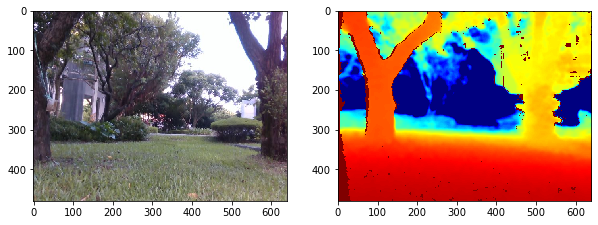

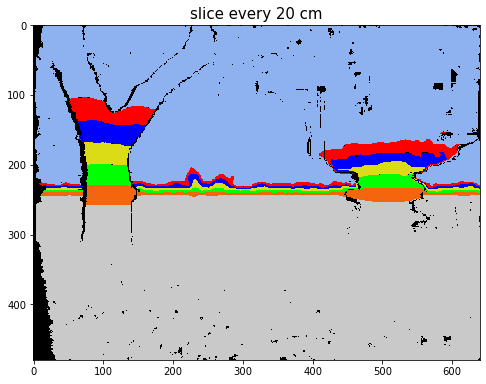

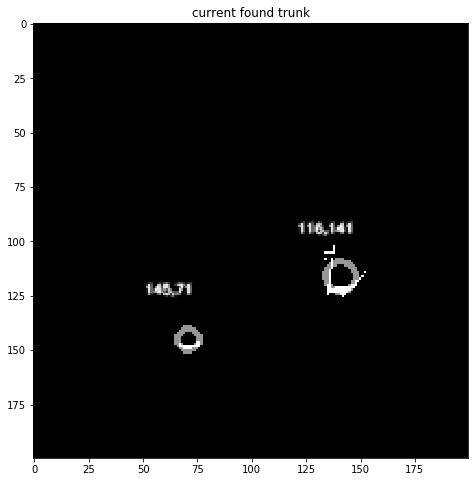

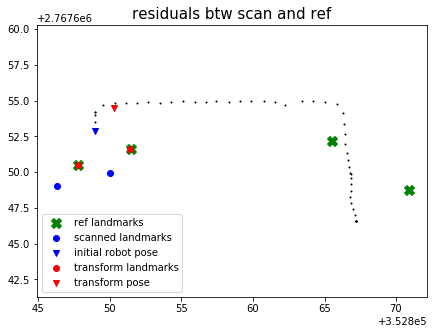

In [13]:
file_path = "/home/ncslaber/mapping_node/mapping_ws/src/mapping_explorer/0906_demo_data/20/"

''' show raw data '''
npDepth = np.load(file_path+"depth.npy")
npColor = np.load(file_path+"color.npy")
npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

''' to world coordinate '''
cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

''' depth segmentation: show layers '''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<300]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
npHeight_seg = npHeight_seg.astype('uint8')
fig2,ax = plt.subplots(figsize=(8,8))
plt.title('slice every 20 cm', fontsize=15)
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))

''' top-down view grid '''
def depth_Z(u,v):
    return npDepth[v][u]
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape

for v in range(row):
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)
                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100] += 1
                    
hieght_or = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
hieght_or[plane_l1>8]=255
hieght_or = hieght_or.astype('uint8')
kernel = np.ones((2,2), np.uint8)
hieght_or = cv2.dilate(hieght_or,kernel,iterations = 1)
hieght_or = cv2.erode(hieght_or, kernel, iterations = 1)
# fig, ax = plt.subplots(figsize=(8,8))
# plt.title('filter grid > 4', fontsize=15)
# plt.imshow(cv2.cvtColor(hieght_or, cv2.COLOR_BGR2RGB))

''' find connected component and push into point array A '''
num_objects, labels = cv2.connectedComponents(hieght_or)
centre_x_list = []
centre_y_list = []
circle_bd = np.zeros(hieght_or.shape, dtype=np.uint8)
print('>>>>num_objects:',num_objects)
for i in range(num_objects-1):
    A = []
    for x in range(200):
        for y in range(200):
            if labels[x][y] == i+1:
                A.append(np.array([-x/(x*x+y*y), -y/(x*x+y*y), -1/(x*x+y*y)]))
    A = np.asarray(A)
    print('# of points: ',A.shape)
    if A.shape[0] < 10:
        continue

    k = np.linalg.inv(A.T @ A)
    k = k @ A.T
    k = k @ np.ones((k.shape[1],1))
    centre_x = k[0][0]/(-2)
    centre_y = k[1][0]/(-2)
    radius_r = np.sqrt(centre_x*centre_x+centre_y*centre_y-k[2][0])
    print('x,y,r: ', int(centre_x+0.5), int(centre_y+0.5), int(radius_r+0.5))
    
    cv2.circle(circle_bd,(int(centre_y+0.5), int(centre_x+0.5)), int(radius_r+0.5), 150, 2)
    
    centre_x_list.append(int(centre_x+0.5))
    centre_y_list.append(int(centre_y+0.5))

    cv2.putText(circle_bd, #numpy array on which text is written
                str(int(centre_x+0.5))+','+str(int(centre_y+0.5)), #text
                (int(centre_y)-20,int(centre_x)-20), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.2, #font size
                255, #font color
                1, cv2.LINE_AA) #font stroke
circle_bd[hieght_or==255]=255
centre_x_list = np.asarray(centre_x_list)
centre_y_list = np.asarray(centre_y_list)

fig3 = plt.figure(figsize=(8,8))
plt.title('current found trunk')
plt.imshow(cv2.cvtColor(circle_bd, cv2.COLOR_BGR2RGB))

''' load robot current pose '''
with open(file_path+'cb_pose.csv', 'r') as csvfile:
    imu_yaw, lat, lng = csv.reader(csvfile, delimiter=',')
imu_yaw = float(imu_yaw[0])
lat = float(lat[0])
lng = float(lng[0])

_, _, zone, R = utm.from_latlon(lat, lng)
proj = Proj(proj='utm', zone=zone, ellps='WGS84', preserve_units=False)
utm_x_loc, utm_y_loc = proj(lng, lat)

cX_m_loc = (centre_y_list-100)*0.05
cY_m_loc = (200-centre_x_list)*0.05
cX_utm_loc = cX_m_loc*np.cos(imu_yaw)-cY_m_loc*np.sin(imu_yaw) + utm_x_loc
cY_utm_loc = cX_m_loc*np.sin(imu_yaw)+cY_m_loc*np.cos(imu_yaw) + utm_y_loc
center_utm_loc = np.vstack((cX_utm_loc,cY_utm_loc))
np.save(file_path+'center_utm_loc', center_utm_loc) #############3

''' load landmark map '''
directory = '/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/'
bag_name = 'ntu_test3_2021-07-25-18-23-39/'
file_path_map = directory+bag_name
center_utm_ref = np.load(file_path_map+'center_utm_ref.npy')

cX_utm_ref = center_utm_ref[0,:]
cY_utm_ref = center_utm_ref[1,:]
# fig4 = plt.figure(figsize=(8,8))
# plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='reference landmarks', marker='X',s=100)
# # plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
# plt.axis('equal')
# plt.title('global map in UTM', fontsize=15)
# plt.legend()
# plt.draw()

fig5 = plt.figure(figsize=(7,5))
plt.scatter(cX_utm_ref, cY_utm_ref, c='g', label='ref landmarks', marker='X',s=100)
# plt.scatter(utm_x_ref, utm_y_ref, label='start_recording',c='black')
plt.scatter(cX_utm_loc, cY_utm_loc, label='scanned landmarks',c='b')
plt.scatter(utm_x_loc, utm_y_loc, label='initial robot pose',c='b', marker="v")

''' find rigid transformation '''
P = center_utm_ref
U = center_utm_loc
resid_scalar = 50

def find_second(row_index, first_min):
    second_min = 100
    sm_index = 0
    row_list = D[row_index,:]
    for i in range(len(row_list)):
        if row_list[i] != first_min:
            if row_list[i] < second_min:
                second_min = row_list[i]
                sm_index = i
    
    return second_min, sm_index
count = 0
while resid_scalar > 1:
    count += 1
    D = dist.cdist(U.T, P.T)
    print('>>>> start to ICP >>>>')
    print('dist: ', D)
    # rows = D.min(axis=1)
    cols = D.argmin(axis=1)
    print('match point: ', list(enumerate(cols)))

    for a in range(len(cols)):
        b=1
        while a+b < len(cols):
            if cols[a] == cols[a+b]:
                print("matched same ref landmarks!")
                second_min_A,A = find_second(a,D[a,cols[a]])
                second_min_B,B = find_second(a+b,D[a+b,cols[a+b]])
                if second_min_A>second_min_B:
                    cols[a+b]=B
                elif second_min_A<second_min_B:
                    cols[a]=A
                print('changed point: ', list(enumerate(cols)))
            b+=1
        
    Q = np.zeros(U.shape)
    for (row, col) in enumerate(cols):
        Q[:,row] = P[:,col]

    U_bar = np.array([np.average(U, axis=1)])
    U_bar = U_bar.T
    Q_bar = np.array([np.average(Q, axis=1)])
    Q_bar = Q_bar.T

    X = U-U_bar
    Y = Q-Q_bar
    S = X @ Y.T
    u, s, vh = np.linalg.svd(S)
    # check u, vh det
    print('det(vh@u.T): ',np.linalg.det(vh@u.T))
    det = np.linalg.det(vh@u.T)
    if det>0:
        tmp = np.array([[1,0],[0,1]])
    else: 
        tmp = np.array([[1,0],[0,-1]])
    R = vh @ tmp @ u.T
    t = Q_bar-U_bar

    print('R: ',R)
    print('theta (deg): ',(np.arctan2(-R[1,0], R[0,0]))/np.pi*180)
    print('translation: ',t)
    
    U_new = R@X+U_bar+t
    utm_loc = np.array([[utm_x_loc],[utm_y_loc]])
    utm_loc_decentral = utm_loc-U_bar
    utm_loc_new = R@utm_loc_decentral+U_bar+t
    
    # calculate residuals
    residuals = Q-U_new
    residuals = np.absolute(residuals)
    resid_scalar = residuals.sum()
    print("residual = ",resid_scalar)
    U = U_new
    utm_x_loc = utm_loc_new[0][0]
    utm_y_loc = utm_loc_new[1][0]
    print("iteration time: ", count)
    if count>4:
        print("iterate over 5 times!!")
        break

''' plot result '''
traj = np.load('/home/ncslaber/109-2/210725_NTU_leftAreaLibrary/ntu_test2_2021-07-25-17-42-59/traj_GPS_filtered.npy')
traj_x = traj[0,:]
traj_y = traj[1,:]
plt.scatter(traj_x[0:len(traj_x)-300:100], traj_y[0:len(traj_y)-300:100],c='black',s=1)

plt.scatter(U_new[0,:], U_new[1,:], label='transform landmarks',c='r')
plt.scatter(utm_loc_new[0], utm_loc_new[1], label='transform pose',c='r', marker="v")

plt.axis('equal')
plt.title('residuals btw scan and ref', fontsize=15)
plt.legend()
plt.show()

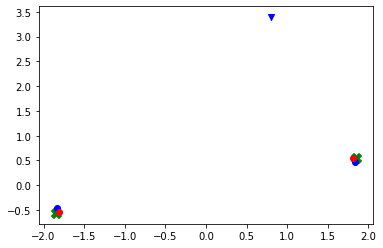

In [110]:
plt.scatter(Y[0,:], Y[1,:], c='g', label='ref landmarks', marker='X', s=100)
plt.scatter(X[0,:], X[1,:], label='scanned landmarks',c='b')
plt.scatter(a[0,:], -a[1,:], label='scanned landmarks',c='r')
plt.scatter(utm_loc_decentral[0], utm_loc_decentral[1], label='origin pose',c='b', marker="v")

In [108]:
a = R@X

In [94]:
np.linalg.matrix_rank(S)

1

In [99]:
vh

array([[-0.95750819, -0.28840608],
       [ 0.28840608, -0.95750819]])

In [100]:
u

array([[-0.96984475, -0.24372354],
       [-0.24372354,  0.96984475]])

In [101]:
s

array([7.29771434e+00, 2.12609528e-16])

In [105]:
vh

array([[-0.95750819, -0.28840608],
       [ 0.28840608, -0.95750819]])

In [106]:
u

array([[-0.96984475, -0.24372354],
       [-0.24372354,  0.96984475]])